# Homework 25

Sections 14.4 and 14.5 of Murphy

Math 404

Winter 2020

Logan Schelly

In [1]:
import numpy as np
import pandas as pd
from scipy import linalg as la
from matplotlib import pyplot as plt
from sklearn.gaussian_process.kernels import RBF
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.datasets import make_moons, load_iris
from lsv3dp.engineer import loadSignUpRatePredictionTable, createSignUpRatePredictionTable, createEnrollmentTable
from lsv3dp import engineer

Implement kernelized PCA using an RBF kernel (https://en.wikipedia.org/wiki/Radial_basis_function_kernel).  Your function should take in an array of data, a tuning parameter, and the number of components.  It should then return the projected data set.

In [2]:
#Make a transformer class.  Follow sklearn format.
class MyRBFKernelPCA(TransformerMixin, BaseEstimator):
    
    def __init__(self, sigma=1, n_components=2):
        self.sigma = sigma
        self.kernel = RBF(length_scale = self.sigma)
        self.n_components = n_components
    
    def fit(self, X, y=None):
        N = X.shape[0]
        #Save the datapoints.
        self.data = X.copy()
        #Calculate the Gram matrix.
        K = self.kernel(X)
        #Calculate the centering matrix.
        H = np.eye(N) - 1/N #* np.ones((N,N))
        #Find tilde-hat K
        K_tilde = H.dot(K.dot(H))
        #Calculate the additional mean shift that someone can't do without the Gram matrix.  Need during transform.
        self.rest_of_mean_shift = (-K + K.mean(axis=0, keepdims=True)).mean(axis=1, keepdims=True)
        #Find largest n_components eigenvectors of the Gram matrix.
        nc = self.n_components
        Lambda, self.U = la.eigh(K_tilde, eigvals=(N-nc, N-1))
        self.lambda_sqrt_inv = Lambda**(-.5)
        
    def transform(self, X):
        Xi = self.data
        kernel = self.kernel
        U = self.U
        l_inv_sqrt = self.lambda_sqrt_inv
        k = kernel(X, Xi)
        k_tilde = k - k.mean(axis=1, keepdims=True) + self.rest_of_mean_shift
        return k_tilde.dot(U * l_inv_sqrt)

After implementing KPCA compare it to regular PCA (using plots and text) on the following data sets:

In [3]:
#Write a function that takes a dataset and the labels, runs KPCA and PCA on both, and plots both separately.
def plotPCAvsKernelPCA(data, label=None, label_name=None, sigma_vals=[.1, 1, 10], alpha=1):
    
    if (label is not None) and (label_name is None):
        label_name = np.unique(label)
    
    #Set up plots.
    plt_height = 7
    naxes = len(sigma_vals) + 1
    ncols = 2
    nrows = (naxes + 1)//ncols
    fig_height = plt_height * nrows
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, fig_height))
    ax0 = axes.ravel()[0]
    
    #Do PCA
    tfmer = PCA(n_components=2, random_state=123)
    tfmer.fit(data)
    X = tfmer.transform(data)
    if label_name is None:
        ax0.scatter(X[:,0], X[:,1], alpha=alpha)
    else:
        for l, ln in zip(np.unique(label), label_name):
            mask = label == l
            ax0.scatter(X[mask, 0], X[mask, 1], label=str(ln), alpha=alpha)
            leg = ax0.legend()
            #Set opacity of markers to 1.
            for lh in leg.legendHandles: 
                lh.set_alpha(1)
            
    ax0.set_title("Normal PCA")
    
    for ax, sigma in zip(axes.ravel()[1:], sigma_vals):
        tfmer = MyRBFKernelPCA(sigma=sigma, n_components=2)
        tfmer.fit(data)
        X = tfmer.transform(data)
        if label_name is None:
            ax.scatter(X[:,0], X[:,1], alpha=alpha)
        else:
            for l, ln in zip(np.unique(label), label_name):
                mask = label == l
                ax.scatter(X[mask, 0], X[mask, 1], label=str(ln), alpha=alpha)
        ax.set_title("KPCA with RBF(sigma = {0})".format(sigma))
    
    return fig, axes

### 1.  The IRIS data set.


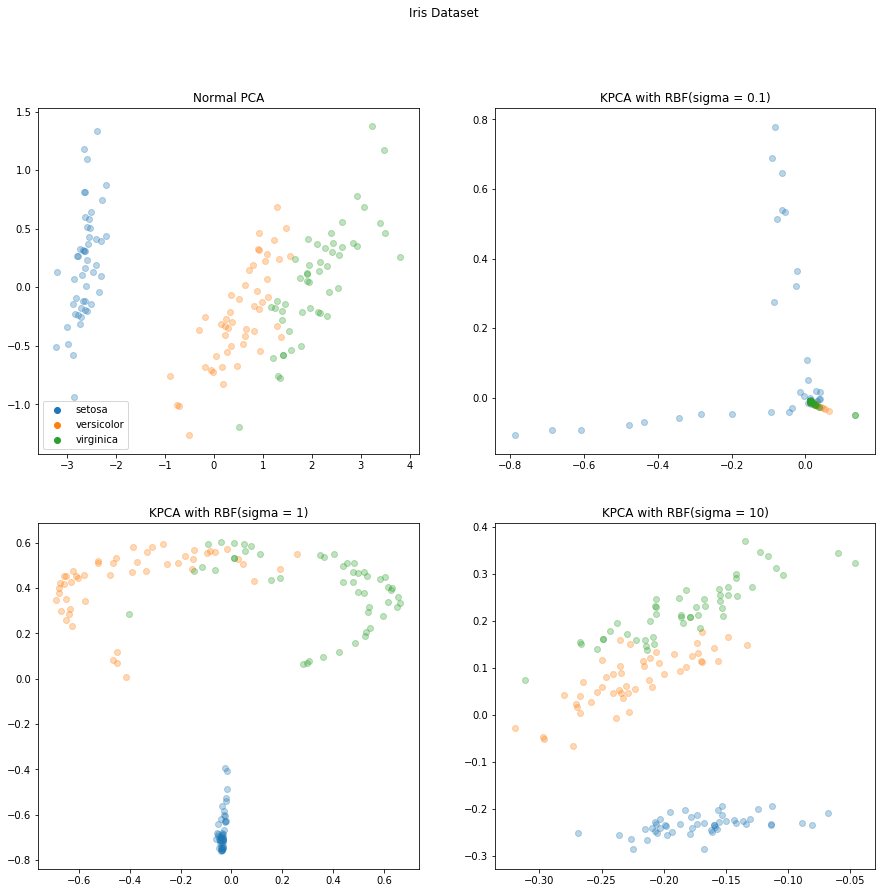

In [4]:
iris = load_iris()
fig, axes = plotPCAvsKernelPCA(iris.data, iris.target, iris.target_names,alpha = .3)
fig.suptitle("Iris Dataset")
plt.show()

### 2. The half moon data set

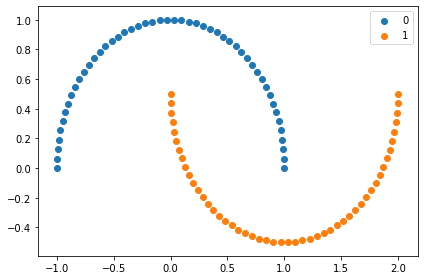

In [5]:
X, y = make_moons(n_samples=100, random_state=123)
plt.scatter(X[y==0, 0], X[y==0, 1], label="0")
plt.scatter(X[y==1, 0], X[y==1, 1], label='1')
plt.tight_layout()
plt.legend()
plt.show()

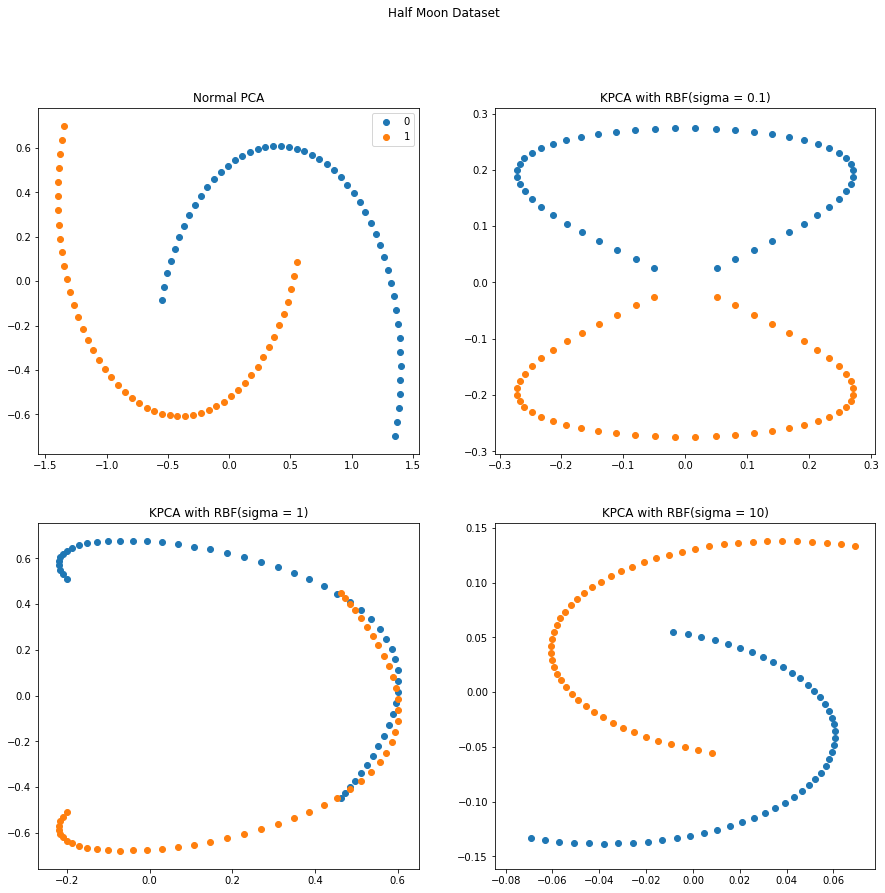

In [6]:
fig, axes = plotPCAvsKernelPCA(X, y)
fig.suptitle("Half Moon Dataset")
plt.show()

### 3. A dataset of your choice

In [7]:
surpdf = loadSignUpRatePredictionTable()
surpdf.signUpBin /= pd.to_timedelta('1 hour')
X = surpdf.drop(columns='nSignUps', level=0)
y = surpdf.nSignUps

In [8]:
#X.head(5) #These are the features.

In [9]:
#y.head(5) #This is the ultimate target.

For my dataset, I'd like to know if Falls are distinguishable from Winters.
I'd also like to know if Springs are distinguishable from Summers (aside from the fact that 111 and 290 are not offered in spring/summer)
Finally, I'd like to know if Thursdays are distinguishable from Wednesdays.

I want to know this, so I can determine if I can encode these pairs as a single variable without losing information.

To investigate this question, I will cluster the other information with these variables as labels.
I will also drop enrollment information, because it 

In [10]:
termLabels = surpdf.loc[:,'term']
#Drop 213 because it is only in Fall (so far).
features = surpdf.drop(columns=[('term',''), ('date', ''), ('nSignUps', '213'), ('enrollment', '213')])
dayDummies = pd.get_dummies(surpdf.weekday)
dayDummies.drop(columns='Monday')
#give dayDummies a multiindex for columns.
dayDummies.columns = [(c,'') for c in dayDummies.columns]
features = pd.concat((features.drop(columns='weekday', level=0), dayDummies), axis=1)
features

signUpBin nSignUps                                  ... enrollment       \
                     110 111 112 113 116 118 119 290 302  ...        313  314   
0           8.5        0   0   0   0   0   0   0   0   0  ...        378  275   
1           9.0        3   0   0   0   0   0   0   0   0  ...        378  275   
2           9.5        0   0   0   0   0   0   1   0   2  ...        378  275   
3          10.0        0   1   0   1   0   0   1   0   0  ...        378  275   
4          10.5        0   0   0   0   0   0   0   0   0  ...        378  275   
...         ...      ...  ..  ..  ..  ..  ..  ..  ..  ..  ...        ...  ...   
58171      18.0        0   0   0   0   0   0   0   1   2  ...          0  277   
58172      18.5        0   0   0   0   0   0   0   0   3  ...          0  277   
58173      19.0        0   0   0   0   0   0   0   0   1  ...          0  277   
58174      19.5        0   0   0   0   0   0   0   1   0  ...          0  277   
58175      20.0        0   0   0   0   0   0   0   0   0  ...          0  277   

           Friday Monday Saturday Sunday Thursday Tuesday Wednesday  
       334                                                           
0      213      0      0        0      0        0       1         0  
1      213      0      0        0      0        0       1         0  
2      213      0      0        0      0        0       1         0  
3      213      0      0        0      0        0       1         0  
4      213      0      0        0      0        0       1         0  
...    ...    ...    ...      ...    ...      ...     ...       ...  
58171  171      0      0        0      0        1       0         0  
58172  171      0      0        0      0        1       0         0  
58173  171      0      0        0      0        1       0         0  
58174  171      0      0        0      0        1       0         0  
58175  171      0      0        0      0        1       0         0  

[58176 rows x 34 columns]

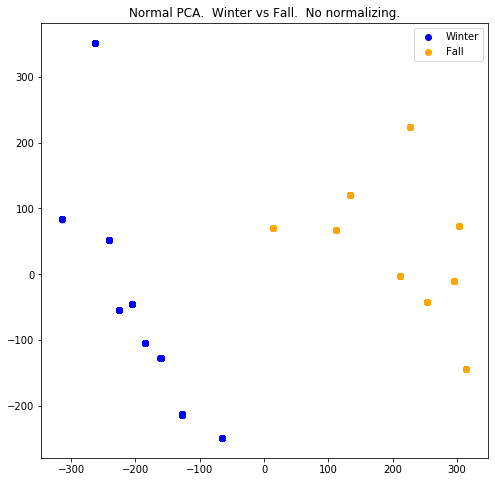

In [11]:
#Do PCA without normalizing.
plt.figure(figsize = (8, 8))
tfmer = PCA(n_components=2, random_state=123)
subset = features.loc[termLabels.isin(['Winter', 'Fall'])]
labelsSubset = termLabels[termLabels.isin(['Winter', 'Fall'])]
tfmer.fit(subset)
X = tfmer.transform(subset)
for sem, color in zip(['Winter', 'Fall'], ['Blue', 'Orange']):
    mask = (labelsSubset == sem)
    plt.scatter(X[mask, 0], X[mask, 1], label=str(sem), alpha=.1, color=color)
leg = plt.legend()
#Set opacity of markers to 1.
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.title("Normal PCA.  Winter vs Fall.  No normalizing.")
plt.show()

In [12]:
#What are the components?
pd.DataFrame(tfmer.components_, index=[0,1], columns=features.columns).enrollment

110       111       112       113       116       118       290  \
0  0.157563  0.026706  0.945196 -0.029304  0.170933  0.084537  0.110458   
1  0.088474 -0.002962  0.106864 -0.311954 -0.628935 -0.567973  0.003569   

        302       303       313       314       334  
0  0.098255 -0.106208 -0.038944 -0.034556 -0.089360  
1  0.038443 -0.036738 -0.393998 -0.025534 -0.080644

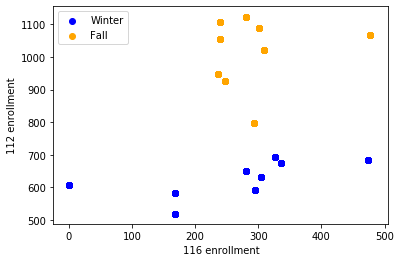

In [13]:
#What happens if we plot 116 enrollment vs 112 enrollment?
for sem, color in zip(['Winter', 'Fall'], ['Blue', 'Orange']):
    x = features.enrollment.loc[termLabels == sem,'116']
    y = features.enrollment.loc[termLabels == sem,'112']
    plt.scatter(x, y, color=color, alpha=.1, label=sem)
leg = plt.legend()
#Set opacity of markers to 1.
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel("116 enrollment")
plt.ylabel("112 enrollment")
plt.show()

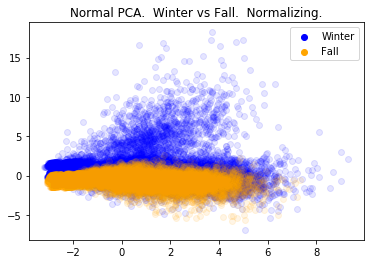

In [14]:
#Normalize.
normalizedFeatures = features / features.std()
subset = normalizedFeatures.loc[termLabels.isin(['Winter', 'Fall'])]
labelsSubset = termLabels[termLabels.isin(['Winter', 'Fall'])]
tfmer.fit(subset)
X = tfmer.transform(subset)
for sem, color in zip(['Winter', 'Fall'], ['Blue', 'Orange']):
    mask = (labelsSubset == sem)
    plt.scatter(X[mask, 0], X[mask, 1], label=str(sem), alpha=.1, color=color)
leg = plt.legend()
#Set opacity of markers to 1.
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.title("Normal PCA.  Winter vs Fall.  Normalizing.")
plt.show()

In [15]:
#What are the principal directions?

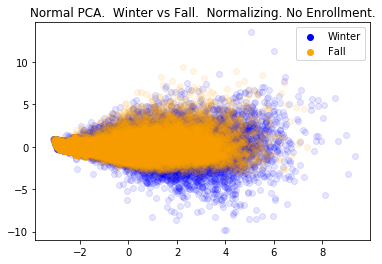

In [16]:
#Normalize while dropping enrollment, since we only have 8-16 observations of enrollment.
normalizedFeaturesNoEnrollment = normalizedFeatures.drop(columns='enrollment', level=0)
subset = normalizedFeaturesNoEnrollment.loc[termLabels.isin(['Winter', 'Fall'])]
labelsSubset = termLabels[termLabels.isin(['Winter', 'Fall'])]
tfmer.fit(subset)
X = tfmer.transform(subset)
for sem, color in zip(['Winter', 'Fall'], ['Blue', 'Orange']):
    mask = (labelsSubset == sem)
    plt.scatter(X[mask, 0], X[mask, 1], label=str(sem), alpha=.1, color=color)
leg = plt.legend()
#Set opacity of markers to 1.
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.title("Normal PCA.  Winter vs Fall.  Normalizing. No Enrollment.")
plt.show()

In [17]:
surpdf.groupby('term').mean().nSignUps

/home/lschelly/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:3946: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


110       111       112       113       116       118       119  \
term                                                                           
Fall    0.367420  0.169658  4.623350  3.196009  0.088800  0.530631  0.000361   
Spring  0.093112  0.078550  1.704719  1.382759  0.021259  0.193452  0.161458   
Summer  0.151350  0.011568  1.615788  1.201585  0.025707  0.083012  0.139889   
Winter  0.498453  0.116816  4.696158  4.315170  0.104042  0.701248  0.484581   

             213       290       302       303       313       314       334  
term                                                                          
Fall    0.157127  0.625464  1.413263  0.461066  2.067502  1.106487  1.516708  
Spring  0.000000  0.263074  0.000000  0.000106  0.822917  0.737883  0.838329  
Summer  0.000000  0.000000  0.000000  0.000107  0.576371  0.490681  1.070908  
Winter  0.000000  0.635429  0.781936  0.967465  2.126946  1.308234  1.937824

In [18]:
#Are they distinguishable if you 

In [19]:
surpdf.loc[surpdf.term == 'Fall',:].enrollment.mean()

110     403.719059
111     129.205446
112    1012.285891
113     576.331683
116     293.314356
118     304.607673
213      43.762376
290     204.097772
302     129.686881
303      54.357673
313     384.664604
314     229.941832
334     189.547030
dtype: float64

In [20]:
surpdf.loc[surpdf.term == 'Winter',:].enrollment.mean()

110    338.847904
111    115.702994
112    626.108982
113    636.977246
116    261.037126
118    298.918563
213      0.000000
290    166.789222
302     84.898204
303    107.089820
313    429.185629
314    259.095808
334    238.395210
dtype: float64

In [21]:
surpdf.loc

In [22]:
bleh = surpdf.copy()
bleh['year'] = bleh.date.dt.year
bleh.drop(columns='date', level=0, inplace=True)
x = bleh.loc[:,['enrollment', 'term', 'year']].groupby(['year', 'term']).mean()
x

enrollment                                                     \
                   110  111   112  113  116  118  213  290  302  303  313   
year term                                                                   
2011 Fall          486  152  1068  598  477  404    0  253  119   56  417   
     Spring        107   31    82   86    0    0    0    0    0    0   78   
     Summer        114   31    91   78    0    0    0    0    0    0   69   
     Winter        419  125   608  560    0    0    0  215   95  121  378   
2012 Fall          515  135  1107  607  239  295    0  254  132   38  404   
     Spring         84   27    85   77  105  105    0    0    0    0   81   
     Summer         94   32    71   62   78   51    0    0    0    0   65   
     Winter        434  143   683  673  473  481    0  226   61   87  394   
2013 Fall          434  169   948  502  236  259    0  174   99   45  367   
     Spring         53   34    94   83   53   61    0   32    0    0   97   
     Summer         84   30    83   58   39   37    0    0    0    0   60   
     Winter        426  128   583  638  169  272    0  182   71  101  405   
2014 Fall          405  131   798  416  294  331    0  177  126   36  332   
     Spring         69   16    94   73   39   74    0   19    0    0   59   
     Summer         61    0    50   40   37   35    0    0    0    0   52   
     Winter        321   82   519  542  168  281    0  131   61   84  359   
2015 Fall          358  154   927  563  248  289    0  189  132   55  381   
     Spring         64   17    94   95   36  105    0   23    0    0   74   
     Summer         69    0    86   56   59   31    0    0    0    0   45   
     Winter        278  104   591  563  295  371    0  142   75  103  367   
2016 Fall          405  130  1021  652  309  295    0  196  144   63  408   
     Spring         55   29   116   86   51  106    0   30    0    0   57   
     Summer         53    0    73   64   34   45    0    0    0    0   82   
     Winter        340  139   633  665  305  337    0  168   93  113  458   
2017 Fall          373   86  1122  694  281  289    0  225  132   53  474   
     Spring         37   13   112   84   48   73    0   31    0    0   56   
     Summer         48    0    69   49   50   34    0    0    0    0   57   
     Winter        322  129   692  716  326  441    0  151   76  117  519   
2018 Fall          322   92  1089  584  301  282    0  204  153   74  593   
     Spring         24   14    99   93   45   18    0   31    0    0   46   
     Summer         34    0    66   51   31   20    0    0    0    0   59   
     Winter        277   92   675  695  336  291    0  153  113  108  499   
2019 Fall          307  101  1055  569  240  294  520  155  132   75    0   
     Spring         26   12    85   96   36   20    0   32    0    0   58   
     Summer         34    0    64   62   36   24    0    0    0    0   64   
     Winter        232   99   652  681  280  219    0  133  118  130  482   

                       
             314  334  
year term              
2011 Fall    204  189  
     Spring   53   70  
     Summer   36   73  
     Winter  275  213  
2012 Fall    248  236  
     Spring   76   64  
     Summer   53   55  
     Winter  265  175  
2013 Fall    207  204  
     Spring   60   67  
     Summer   51   80  
     Winter  252  242  
2014 Fall    184  171  
     Spring   72   48  
     Summer   44   58  
     Winter  186  211  
2015 Fall    222  155  
     Spring   81   75  
     Summer   75   73  
     Winter  234  205  
2016 Fall    243  199  
     Spring   80   45  
     Summer   51   57  
     Winter  258  262  
2017 Fall    249  178  
     Spring   63   64  
     Summer   58   65  
     Winter  235  274  
2018 Fall    250  200  
     Spring   56   62  
     Summer   59   43  
     Winter  317  292  
2019 Fall    277  171  
     Spring   66   61  
     Summer   52   46  
     Winter  309  268

In [23]:
x.shape

(36, 13)

In [24]:
edf = createEnrollmentTable()
#Explode the columns
edf = engineer.explodeSignUpRateColumns(edf)
edf

year    term enrollment                                                \
                        110  111   112  113  116  118  213  290  302  303   
0   2002    Fall          0  173   795  454    0    0    0    0  155    0   
1   2002  Spring          0   19    88   76    0    0    0    0    0    0   
2   2002  Summer          0   33    82   66    0    0    0    0    0    0   
3   2002  Winter          0   66   492  554    0    0    0    0    0    0   
4   2003    Fall          0  177   887  495    0    0    0    0  123   72   
..   ...     ...        ...  ...   ...  ...  ...  ...  ...  ...  ...  ...   
65  2019    Fall        307  101  1055  569  240  294  520  155  132   75   
66  2019  Spring         26   12    85   96   36   20    0   32    0    0   
67  2019  Summer         34    0    64   62   36   24    0    0    0    0   
68  2019  Winter        232   99   652  681  280  219    0  133  118  130   
69  2020  Winter        222   99   682  686  295  191  605  140   82  116   

                   
    313  314  334  
0     0    0  249  
1     0    0   40  
2     0    0   77  
3     0    0  306  
4     0    0  223  
..  ...  ...  ...  
65    0  277  171  
66   58   66   61  
67   64   52   46  
68  482  309  268  
69    0  302  284  

[70 rows x 15 columns]

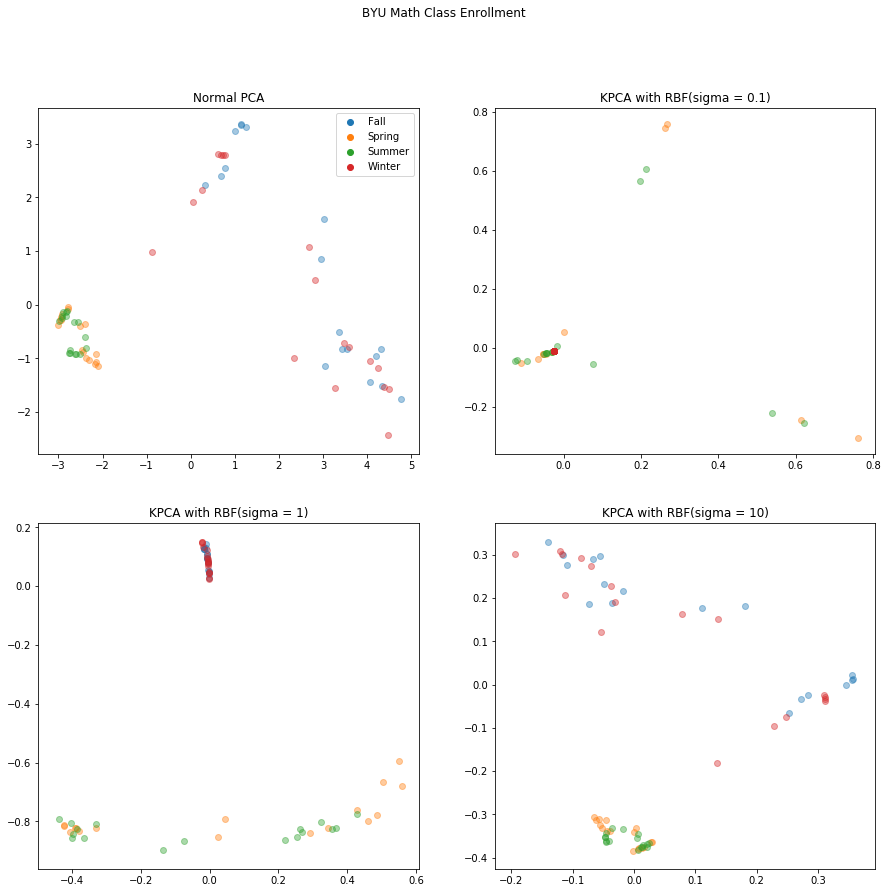

In [31]:
#Run PCA on this now.
X = edf.enrollment
X /= X.std()
y = edf.term
plotPCAvsKernelPCA(X, label=y, sigma_vals=[.1, 1, 10], alpha=.4)
plt.suptitle("BYU Math Class Enrollment")
plt.show()

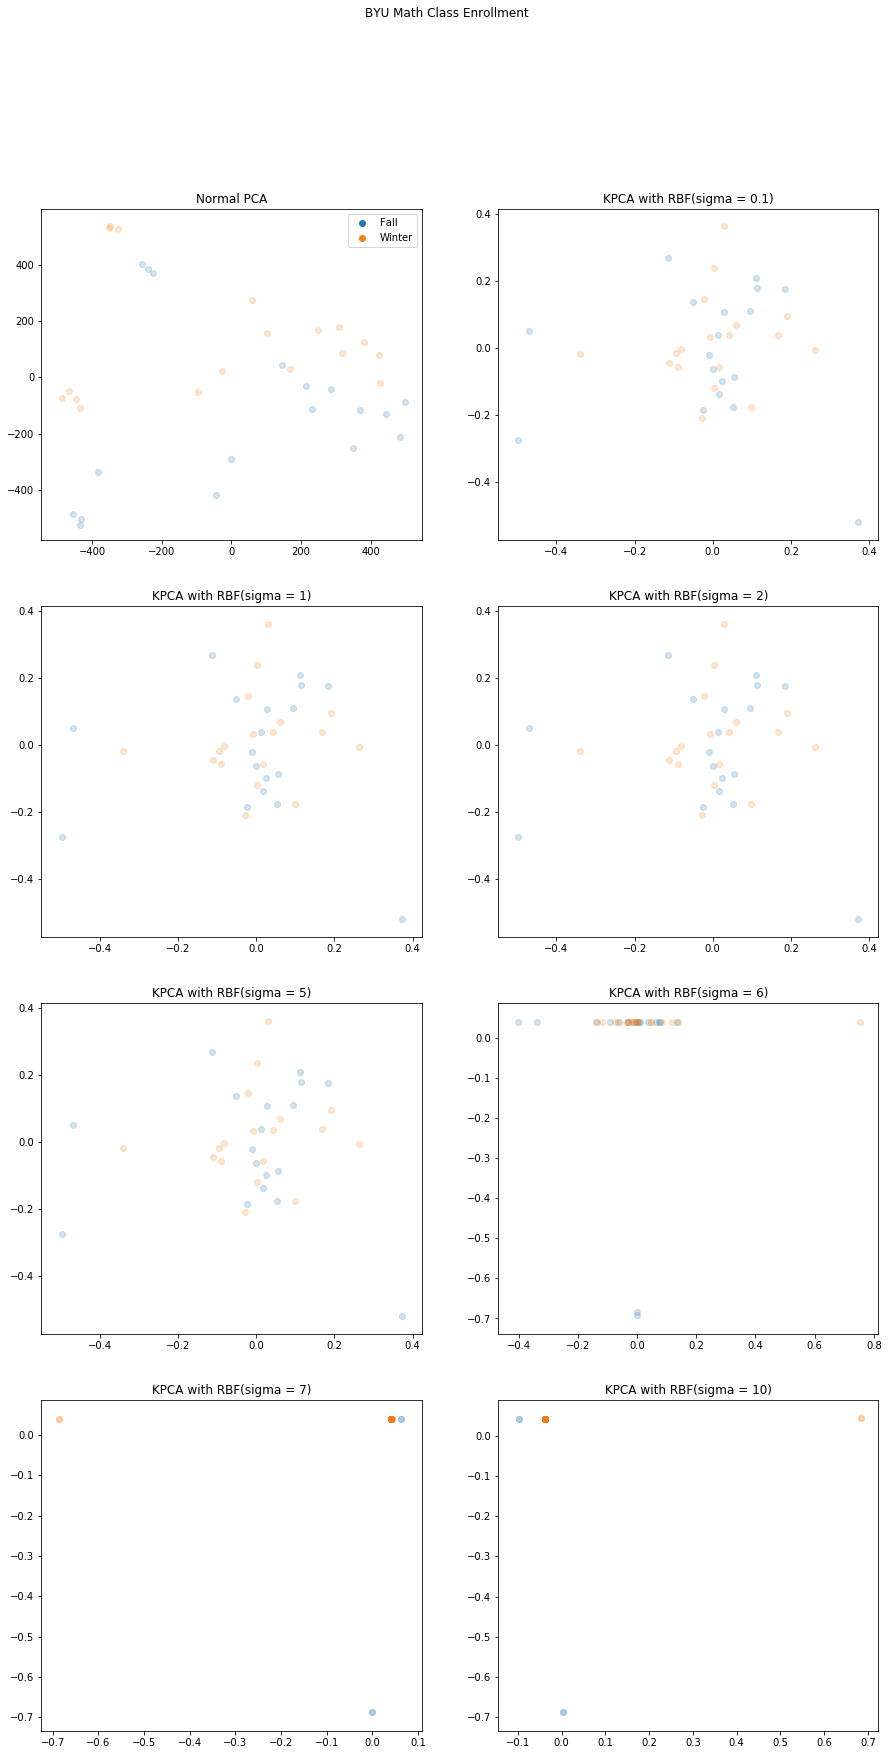

In [28]:
#Try fall vs winter.
mask = y.isin(['Fall', 'Winter'])
plotPCAvsKernelPCA(edf.enrollment[mask], label=y[mask], sigma_vals=[.1, 1, 2, 5, 6, 7, 10], alpha=.2)
plt.suptitle("BYU Math Class Enrollment")
plt.show()

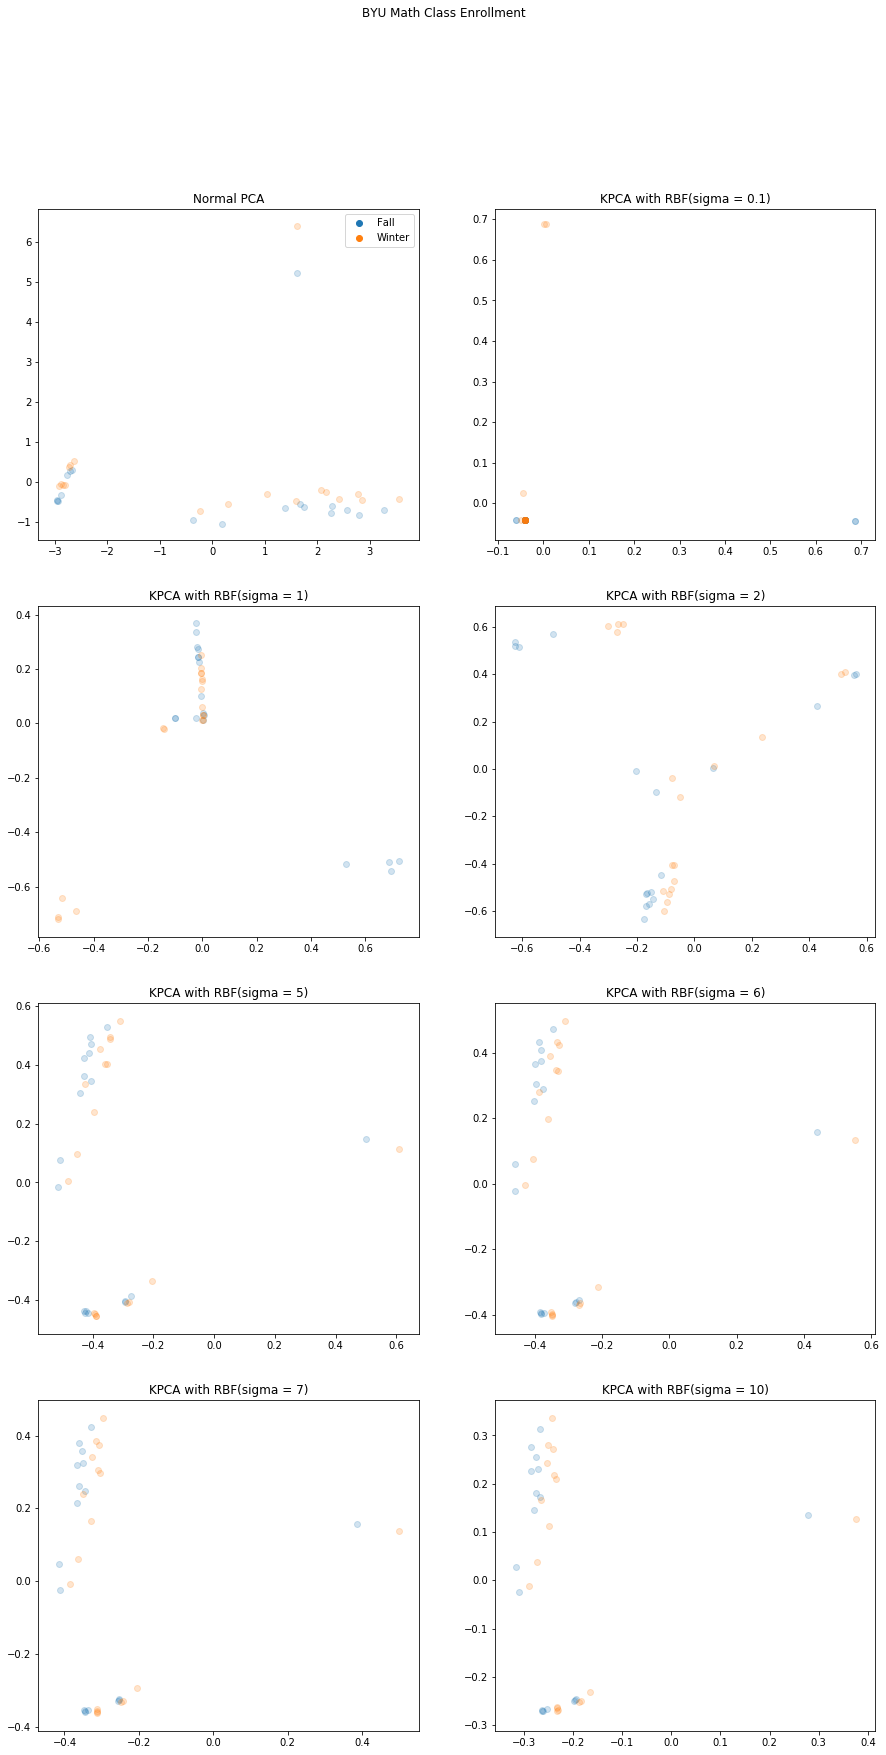

In [29]:
#Try fall vs winter with features normalized.
plotPCAvsKernelPCA(X[mask], label=y[mask], sigma_vals=[.1, 1, 2, 5, 6, 7, 10], alpha=.2)
plt.suptitle("BYU Math Class Enrollment")
plt.show()

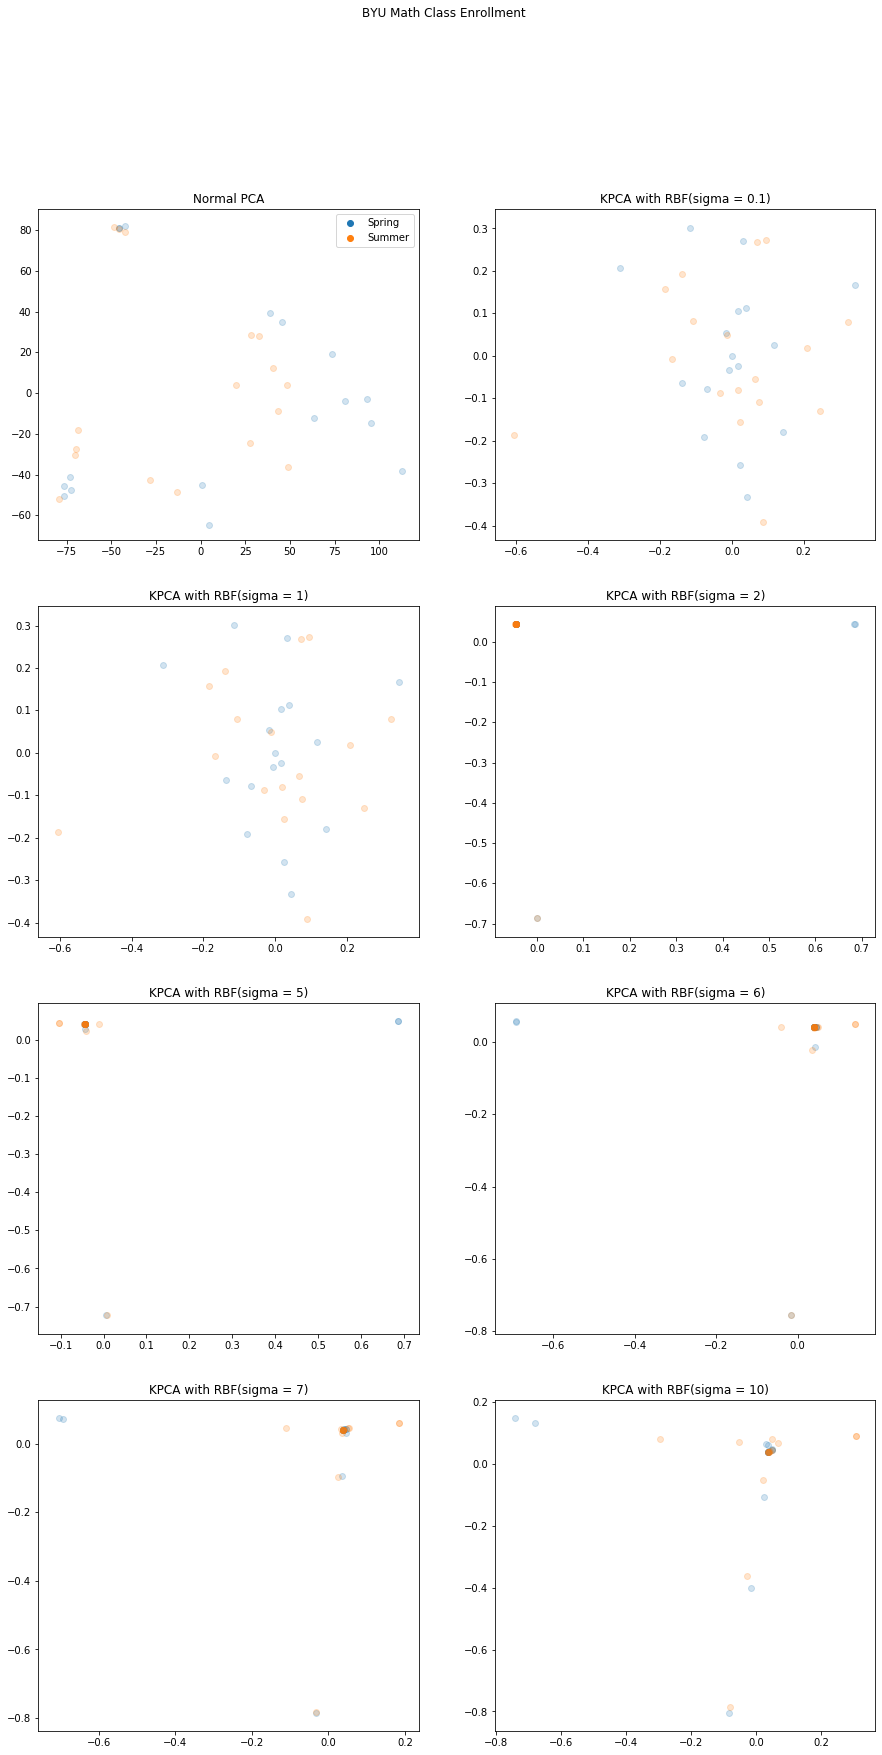

In [32]:
#Try spring vs summer
mask = y.isin(['Spring', 'Summer'])
plotPCAvsKernelPCA(edf.enrollment[mask], label=y[mask], sigma_vals=[.1, 1, 2, 5, 6, 7, 10], alpha=.2)
plt.suptitle("BYU Math Class Enrollment")
plt.show()

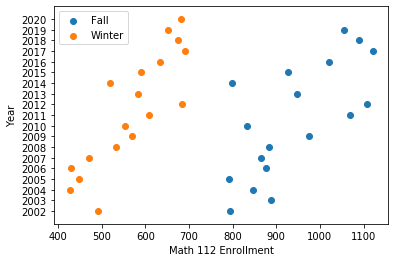

In [42]:
#Can we still use 112 and 116 to linearly separate Fall from Winter?
x = edf.enrollment.loc[:,'112']
y = edf.year
fallMask = edf.term == 'Fall'
winterMask = edf.term == 'Winter'
plt.scatter(x[fallMask],y[fallMask], label='Fall')
plt.scatter(x[winterMask], y[winterMask], label='Winter')
plt.legend()
plt.xlabel("Math 112 Enrollment")
plt.ylabel("Year")
plt.yticks(range(2002, 2021))
plt.show()

In [35]:
#It remains linearly separable on this one feature.  Amazing.